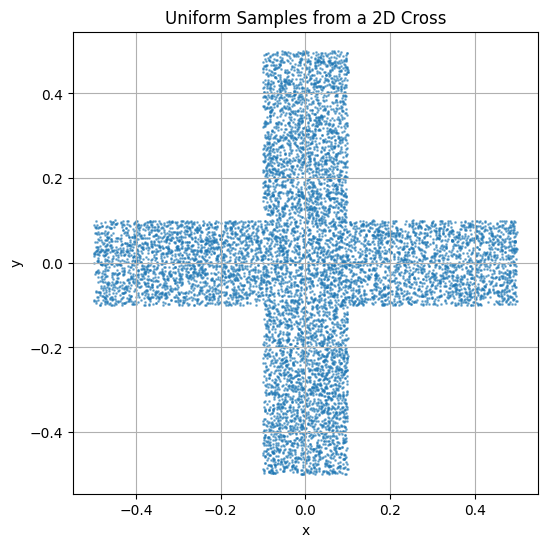

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
w = 0.2  # bar width
h = 1.0  # bar length
n_samples = 10000

# Areas of disjoint regions
area_overlap = w * w
area_vertical_only = w * h - area_overlap
area_horizontal_only = w * h - area_overlap
area_total = area_vertical_only + area_horizontal_only + area_overlap

# Probabilities for region selection
p_vertical = area_vertical_only / area_total
p_horizontal = area_horizontal_only / area_total
p_overlap = area_overlap / area_total

# Generate samples
samples = []
for _ in range(n_samples):
    r = np.random.rand()
    if r < p_vertical:
        # Vertical bar (excluding overlap): x in [-w/2, w/2], y in [-h/2, -w/2] ∪ [w/2, h/2]
        x = np.random.uniform(-w/2, w/2)
        y = np.random.choice([
            np.random.uniform(-h/2, -w/2),
            np.random.uniform(w/2, h/2)
        ])
    elif r < p_vertical + p_horizontal:
        # Horizontal bar (excluding overlap): y in [-w/2, w/2], x in [-h/2, -w/2] ∪ [w/2, h/2]
        y = np.random.uniform(-w/2, w/2)
        x = np.random.choice([
            np.random.uniform(-h/2, -w/2),
            np.random.uniform(w/2, h/2)
        ])
    else:
        # Overlap region: square [-w/2, w/2] × [-w/2, w/2]
        x = np.random.uniform(-w/2, w/2)
        y = np.random.uniform(-w/2, w/2)
    
    samples.append((x, y))

samples = np.array(samples)

# Plot
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.5)
plt.title('Uniform Samples from a 2D Cross')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.grid(True)
plt.show()




In [51]:
import jax
import jax.numpy as jnp
from functools import partial

def kme_RBF_uniform_func(a, b, l, y):
    """
    The implementation of the kernel mean embedding of the RBF kernel with Uniform distribution.
    Not vectorized.

    Args:
        a: float (lower bound)
        b: float (upper bound)
        l: float
        y: float

    Returns:
        kernel mean embedding: scalar
    """
    part1 = jnp.sqrt(jnp.pi / 2) * l / (b - a)
    part2 = jax.scipy.special.erf((b - y) / (l * jnp.sqrt(2))) - jax.scipy.special.erf((a - y) / (l * jnp.sqrt(2)))
    return part1 * part2

def kme_RBF_uniform_func_dim(a, b, l, y):
    """
    The implementation of the kernel mean embedding of the RBF kernel with Uniform distribution.
    Not vectorized.

    Args:
        a: (D,)
        b: (D,)
        l: float
        y: (D,)

    Returns:
        kernel mean embedding: scalar
    """
    kme_RBF_uniform_func_ = partial(kme_RBF_uniform_func, l=l)
    kme_RBF_uniform_vmap_func = jax.vmap(kme_RBF_uniform_func_)
    kme_all_d = kme_RBF_uniform_vmap_func(a=a, b=b, y=y)
    return jnp.prod(kme_all_d)

def kme_RBF_uniform(a, b, l, y):
    """
    The implementation of the kernel mean embedding of the RBF kernel with Gaussian distribution
    A fully vectorized implementation.

    Args:
        a: (D,)
        b: (D,)
        l: float
        y: (M, D)

    Returns:
        kernel mean embedding: (M, )
    """
    kme_RBF_uniform_func_ = partial(kme_RBF_uniform_func_dim, a=a, b=b, l=l)
    kme_RBF_uniform_vmap_func = jax.vmap(kme_RBF_uniform_func_)
    kme_all_d = kme_RBF_uniform_vmap_func(y=y)
    return kme_all_d

In [52]:
def rbf_kernel(x, y, l):
    return jnp.exp(-jnp.sum((x - y) ** 2) / (2 * l ** 2))

# --- Monte Carlo approximation of KME ---
def monte_carlo_kme_uniform(key, a, b, l, y, num_samples=100_000):
    D = a.shape[0]
    samples = jax.random.uniform(key, shape=(num_samples, D), minval=a, maxval=b)
    # samples_1 = jax.random.uniform(key, shape=(num_samples, 1), minval=a[1], maxval=b[1])
    # Concatenate along the second axis to form (N, 2)
    # samples = jnp.concatenate([samples_0, samples_1], axis=1)
    rbf_vals = jax.vmap(lambda x: rbf_kernel(x, y, l))(samples)
    return rbf_vals.mean()

# --- Test code ---
key = jax.random.PRNGKey(42)
D = 2  # input dimension
M = 5 # number of y test points
a = jnp.array([-1.0, -2.0])
b = jnp.array([1.0, 2.0])
l = 0.5
y_test = jax.random.normal(key, shape=(M, D))

kme_vals = kme_RBF_uniform(a, b, l, y_test)

# Monte Carlo estimates
mc_kme_vals = jnp.array([
    monte_carlo_kme_uniform(jax.random.fold_in(key, i), a, b, l, y_test[i])
    for i in range(M)
])

print("Analytical KME values:", kme_vals)
print("Monte Carlo KME values:", mc_kme_vals)
print("Absolute errors:", jnp.abs(kme_vals - mc_kme_vals))

Analytical KME values: [0.18714413 0.17978431 0.18606973 0.03686281 0.1605047 ]
Monte Carlo KME values: [0.18719712 0.17946833 0.18587281 0.03712531 0.1610381 ]
Absolute errors: [5.2988529e-05 3.1597912e-04 1.9691885e-04 2.6249886e-04 5.3340197e-04]


In [ ]:
kme_1 = kme_RBF_uniform(jnp.array([-w/2, -h/2]), jnp.array([w/2, h/2]), l, y_test)
kme_2 = kme_RBF_uniform(jnp.array([-h/2, -w/2]), jnp.array([-w/2, w/2]), l, y_test)
kme_3 = kme_RBF_uniform(jnp.array([w/2, -w/2]), jnp.array([h/2, w/2]), l, y_test)
final_kme = kme_1 * w * h / area_total + kme_2 * (w * h - w * w) / 2 / area_total + kme_3 * (w * h - w * w) / 2 / area_total
print("Final KME value:", final_kme)

for i in range(M):
    mc_kme = jax.vmap(lambda x: rbf_kernel(x, y_test[i], l))(samples)
    print("Monte Carlo KME value:", mc_kme.mean())

Final KME value: [0.8159722  1.0041381  1.0766562  0.01563532 0.18206084]
Monte Carlo KME value: 0.5783424
Monte Carlo KME value: 0.69220436
Monte Carlo KME value: 0.7522531
Monte Carlo KME value: 0.00941362
Monte Carlo KME value: 0.13047732


In [54]:
kme_1

Array([0.6211053 , 0.6917065 , 0.7712232 , 0.00617105, 0.14823881],      dtype=float32)